# Text Classification Assessment

This assessment is a text classification project where the goal is to classify the genre of a movie based on its characteristics, primarily the text of the plot summarization. You have a training set of data that you will use to identify and create your best predicting model. Then you will use that model to predict the classes of the test set of data. We will compare the performance of your predictions to your classmates using the F1 Score. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

The **movie_train.csv** dataset contains information (`Release Year`, `Title`, `Plot`, `Director`, `Cast`) about 10,682 movies and the label of `Genre`. There are 9 different genres in this data set, so this is a multiclass problem. You are expected to primarily use the plot column, but can use the additional columns as you see fit.

After you have identified your best performing model, you will create predictions for the test set of data. The test set of data, contains 3,561 movies with all of their information except the `Genre`. 

Below is a list of tasks that you will definitely want to complete for this challenge, but this list is not exhaustive. It does not include any tasks around handling class imbalance or about how to test multiple different models and tuning hyperparameters, but you should still look at doing those to see if they help you to create a better predictive model.

**Deliverables:** 
    For this project you will have two things you need to create, your predictions on the holdoutset and a notbook detailing your process.  


# Good Luck

### Task #1: Perform imports and load the dataset into a pandas DataFrame


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer
import string
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acumu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [101]:
df = pd.read_csv('data/movie_train.csv', index_col=0)

In [102]:
df.head()

,Release Year,Title,Plot,Director,Cast,Genre
10281,1984,Silent Madness,A computer error leads to the accidental relea...,Simon Nuchtern,"Belinda Montgomery, Viveca Lindfors",horror
7341,1960,Desire in the Dust,"Lonnie Wilson (Ken Scott), the son of a sharec...",Robert L. Lippert,"Raymond Burr, Martha Hyer, Joan Bennett",drama
10587,1986,On the Edge,"A gaunt, bushy-bearded, 44-year-old Wes Holman...",Rob Nilsson,"Bruce Dern, Pam Grier",drama
25495,1988,Ram-Avtar,Ram and Avtar are both childhood best friends....,Sunil Hingorani,"Sunny Deol, Anil Kapoor, Sridevi",drama
16607,2013,Machete Kills,Machete Cortez (Danny Trejo) and Sartana River...,Robert Rodriguez,"Danny Trejo, Michelle Rodriguez, Sofía Vergara...",action


In [4]:
df.shape

(10682, 6)

### Task #2: Check for missing values:

In [5]:
# Check for whitespace strings (it's OK if there aren't any!):

df.isnull().sum()

Release Year      0
Title             0
Plot              0
Director          0
Cast            169
Genre             0
dtype: int64

### Task #3: Remove NaN values:

In [6]:
df.fillna(value = 'unknown', inplace=True)

In [7]:
df.isnull().sum()

Release Year    0
Title           0
Plot            0
Director        0
Cast            0
Genre           0
dtype: int64

### Task #4: Take a look at the columns and do some EDA to familiarize yourself with the data. This will consists of you cleaning up the data set by doing things like removing stop words, tokenizing, and/or lemitizing words. 

In [8]:
df.Genre.value_counts()

drama        3770
comedy       2724
horror        840
action        830
thriller      685
romance       649
western       525
adventure     331
crime         328
Name: Genre, dtype: int64

In [9]:
df.columns

Index(['Release Year', 'Title', 'Plot', 'Director', 'Cast', 'Genre'], dtype='object')

In [10]:
# Drop release year
df.drop(columns=['Release Year'], inplace=True)

In [11]:
df.columns

Index(['Title', 'Plot', 'Director', 'Cast', 'Genre'], dtype='object')

In [12]:
df.shape

(10682, 5)

In [13]:
df['Plot Len'] = df['Plot']
for i in df.index:
    df['Plot Len'][i] = len(df['Plot'][i])
df.head()

,Title,Plot,Director,Cast,Genre,Plot Len
10281,Silent Madness,A computer error leads to the accidental relea...,Simon Nuchtern,"Belinda Montgomery, Viveca Lindfors",horror,175
7341,Desire in the Dust,"Lonnie Wilson (Ken Scott), the son of a sharec...",Robert L. Lippert,"Raymond Burr, Martha Hyer, Joan Bennett",drama,1374
10587,On the Edge,"A gaunt, bushy-bearded, 44-year-old Wes Holman...",Rob Nilsson,"Bruce Dern, Pam Grier",drama,839
25495,Ram-Avtar,Ram and Avtar are both childhood best friends....,Sunil Hingorani,"Sunny Deol, Anil Kapoor, Sridevi",drama,857
16607,Machete Kills,Machete Cortez (Danny Trejo) and Sartana River...,Robert Rodriguez,"Danny Trejo, Michelle Rodriguez, Sofía Vergara...",action,4428


In [14]:
plot_target = df[['Plot', 'Genre']]

In [98]:
plot_target.head()

,Plot,Genre
10281,A computer error leads to the accidental relea...,horror
7341,"Lonnie Wilson (Ken Scott), the son of a sharec...",drama
10587,"A gaunt, bushy-bearded, 44-year-old Wes Holman...",drama
25495,Ram and Avtar are both childhood best friends....,drama
16607,Machete Cortez (Danny Trejo) and Sartana River...,action


In [16]:
stops = stopwords.words('english') + list(string.punctuation)

In [17]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [18]:
def doc_preparer(doc, stop_words=stops):  
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in stop_words]
    print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [ ]:
processed_plot = list(map(doc_preparer, plot_target['Plot']))


In [20]:
len(processed_plot)

10682

In [ ]:
processed_plot

In [22]:
df['Plot Len'] = df['Plot']
for i in df.index:
    df['Plot Len'][i] = len(df['Plot'][i])
df.head()

,Title,Plot,Director,Cast,Genre,Plot Len
10281,Silent Madness,A computer error leads to the accidental relea...,Simon Nuchtern,"Belinda Montgomery, Viveca Lindfors",horror,175
7341,Desire in the Dust,"Lonnie Wilson (Ken Scott), the son of a sharec...",Robert L. Lippert,"Raymond Burr, Martha Hyer, Joan Bennett",drama,1374
10587,On the Edge,"A gaunt, bushy-bearded, 44-year-old Wes Holman...",Rob Nilsson,"Bruce Dern, Pam Grier",drama,839
25495,Ram-Avtar,Ram and Avtar are both childhood best friends....,Sunil Hingorani,"Sunny Deol, Anil Kapoor, Sridevi",drama,857
16607,Machete Kills,Machete Cortez (Danny Trejo) and Sartana River...,Robert Rodriguez,"Danny Trejo, Michelle Rodriguez, Sofía Vergara...",action,4428


In [99]:
plot_target.head()

,Plot,Genre
10281,A computer error leads to the accidental relea...,horror
7341,"Lonnie Wilson (Ken Scott), the son of a sharec...",drama
10587,"A gaunt, bushy-bearded, 44-year-old Wes Holman...",drama
25495,Ram and Avtar are both childhood best friends....,drama
16607,Machete Cortez (Danny Trejo) and Sartana River...,action


### Task #5: Split the data into train & test sets:

Yes we have a holdout set of the data, but you do not know the genres of that data, so you can't use it to evaluate your models. Therefore you must create your own training and test sets to evaluate your models. 

In [24]:
# Separate features and labels 
X = processed_plot
y = plot_target.Genre

# Create test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [ ]:
X

In [26]:
y

10281    horror
7341      drama
10587     drama
25495     drama
16607    action
          ...  
4652      drama
23220    action
15847     drama
3102      drama
3583      drama
Name: Genre, Length: 10682, dtype: object

### Task #6: Build a pipeline to vectorize the date, then train and fit your models.
You should train multiple types of models and try different combinations of the tuning parameters for each model to obtain the best one. You can use the SKlearn functions of GridSearchCV and Pipeline to help automate this process.


In [ ]:
X_train

**Logistic Regression Pipeline**

In [28]:
lr_pipeline = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(min_df=10, max_df=.9, ngram_range = (1, 2))),
    ('lr', LogisticRegression(class_weight='balanced', 
                              solver='saga', 
                              max_iter = 500, 
                              C=1, 
                              penalty='l2', 
                              verbose=1, 
                              n_jobs=-1,
                              random_state=42))
])

In [29]:
lr_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


max_iter reached after 25 seconds


C:\Users\acumu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   25.4s finished


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 2))),
                ('lr',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=500,
                                    n_jobs=-1, random_state=42, solver='saga',
                                    verbose=1))])

In [30]:
pd.DataFrame(lr_pipeline.predict(X_test)).value_counts()

drama        697
comedy       627
romance      259
action       257
horror       233
thriller     204
western      163
crime        150
adventure     81
dtype: int64

In [31]:
# Create function to evaluate model and display confusion matrix
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    
    print(classification_report(y, y_pred))
    
    plot_confusion_matrix(model, X, y, cmap='Blues', xticks_rotation='vertical')

              precision    recall  f1-score   support

      action       0.74      0.91      0.82       621
   adventure       0.78      0.95      0.86       235
      comedy       0.82      0.78      0.80      2032
       crime       0.63      0.99      0.77       249
       drama       0.92      0.63      0.75      2818
      horror       0.86      0.98      0.91       624
     romance       0.57      0.95      0.72       505
    thriller       0.72      0.92      0.81       524
     western       0.84      1.00      0.91       403

    accuracy                           0.80      8011
   macro avg       0.76      0.90      0.82      8011
weighted avg       0.82      0.80      0.79      8011



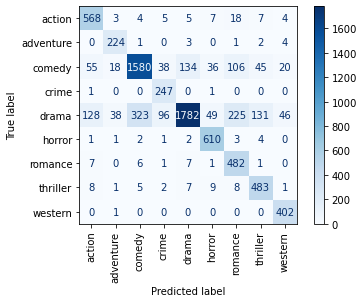

In [32]:
evaluate_model(lr_pipeline, X_train, y_train)

              precision    recall  f1-score   support

      action       0.46      0.56      0.51       209
   adventure       0.60      0.51      0.55        96
      comedy       0.67      0.61      0.64       692
       crime       0.31      0.58      0.40        79
       drama       0.72      0.53      0.61       952
      horror       0.70      0.75      0.72       216
     romance       0.33      0.59      0.42       144
    thriller       0.28      0.35      0.31       161
     western       0.70      0.93      0.80       122

    accuracy                           0.58      2671
   macro avg       0.53      0.60      0.55      2671
weighted avg       0.62      0.58      0.59      2671



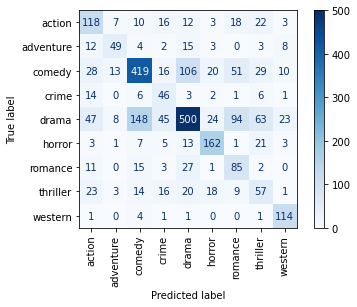

In [33]:
evaluate_model(lr_pipeline, X_test, y_test)

**Logistic Regression Pipeline with Gridsearch**

In [34]:
lr_pipeline_2 = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer()),
    ('lr', LogisticRegression(class_weight='balanced', solver='saga', random_state=42))
])

In [35]:
# Define gridsearch parameters
lr_param_grid = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10],
    'lr__penalty': ['l1', 'l2'],
    'vectorizer__max_df': np.linspace(.7,1,5),
    'vectorizer__min_df': [10],
    'lr__max_iter': [500, 1000],
    'vectorizer__ngram_range': [(1, 2)]
}

In [36]:
# Combine logistic regression pipeline with gridsearch
lr_grid = GridSearchCV(lr_pipeline_2, 
                       lr_param_grid,
                       cv=5,
                       scoring='f1_weighted',
                       verbose=1,
                       n_jobs=-1)

In [37]:
# Fit pipeline with gridsearch 
lr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 44.8min finished
C:\Users\acumu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.001, 0.01, 0.1, 1, 10],
                         'lr__max_iter': [500, 1000],
                         'lr__penalty': ['l1', 'l2'],
                         'vectorizer__max_df': array([0.7  , 0.775, 0.85 , 0.925, 1.   ]),
                         'vectorizer__min_df': [10],
                         'vectorizer__ngram_range': [(1, 2)]},
             scoring='f1_weighted', verbose=1)

In [38]:
# Display best parameters
lr_grid.best_params_

{'lr__C': 10,
 'lr__max_iter': 500,
 'lr__penalty': 'l2',
 'vectorizer__max_df': 0.7,
 'vectorizer__min_df': 10,
 'vectorizer__ngram_range': (1, 2)}

              precision    recall  f1-score   support

      action       0.93      1.00      0.96       621
   adventure       0.94      1.00      0.97       235
      comedy       0.97      0.97      0.97      2032
       crime       0.95      1.00      0.97       249
       drama       0.99      0.92      0.96      2818
      horror       0.97      1.00      0.99       624
     romance       0.89      1.00      0.94       505
    thriller       0.96      1.00      0.98       524
     western       0.97      1.00      0.98       403

    accuracy                           0.97      8011
   macro avg       0.95      0.99      0.97      8011
weighted avg       0.97      0.97      0.97      8011



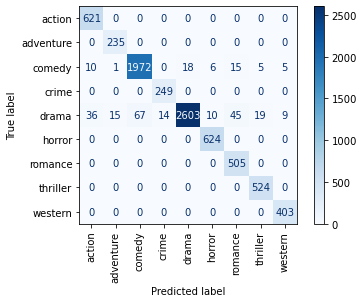

In [39]:
evaluate_model(lr_grid, X_train, y_train)

              precision    recall  f1-score   support

      action       0.51      0.55      0.53       209
   adventure       0.58      0.59      0.59        96
      comedy       0.67      0.64      0.65       692
       crime       0.34      0.38      0.36        79
       drama       0.66      0.65      0.66       952
      horror       0.72      0.73      0.72       216
     romance       0.40      0.42      0.41       144
    thriller       0.31      0.32      0.31       161
     western       0.82      0.84      0.83       122

    accuracy                           0.61      2671
   macro avg       0.56      0.57      0.56      2671
weighted avg       0.62      0.61      0.61      2671



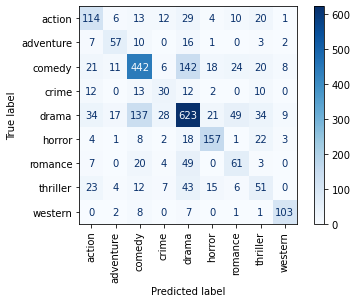

In [40]:
evaluate_model(lr_grid, X_test, y_test)

**Naive Bayes**

In [41]:
nb_pipeline = imbPipeline(steps=[
    ('vectorizer', TfidfVectorizer(min_df=10, max_df=0.9)),
    ('smote', SMOTE(random_state=42)),
    ('nb', MultinomialNB())
])

In [42]:
nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.9, min_df=10)),
                ('smote', SMOTE(random_state=42)), ('nb', MultinomialNB())])

              precision    recall  f1-score   support

      action       0.69      0.78      0.73       621
   adventure       0.51      0.94      0.66       235
      comedy       0.82      0.70      0.76      2032
       crime       0.54      0.95      0.69       249
       drama       0.91      0.52      0.66      2818
      horror       0.76      0.94      0.84       624
     romance       0.40      0.89      0.55       505
    thriller       0.63      0.81      0.71       524
     western       0.78      0.99      0.87       403

    accuracy                           0.71      8011
   macro avg       0.67      0.84      0.72      8011
weighted avg       0.78      0.71      0.71      8011



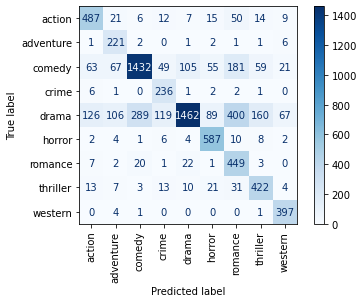

In [43]:
evaluate_model(nb_pipeline, X_train, y_train)

              precision    recall  f1-score   support

      action       0.46      0.49      0.48       209
   adventure       0.42      0.74      0.53        96
      comedy       0.66      0.56      0.61       692
       crime       0.30      0.62      0.41        79
       drama       0.73      0.38      0.50       952
      horror       0.63      0.78      0.70       216
     romance       0.26      0.67      0.37       144
    thriller       0.21      0.29      0.24       161
     western       0.68      0.97      0.80       122

    accuracy                           0.52      2671
   macro avg       0.48      0.61      0.51      2671
weighted avg       0.60      0.52      0.53      2671



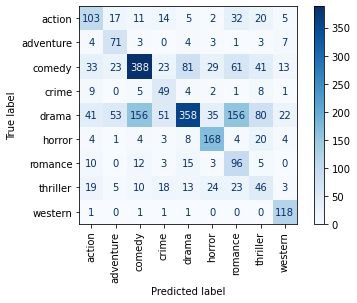

In [44]:
evaluate_model(nb_pipeline, X_test, y_test)

**Naive Bayes with GridSearch**

In [45]:
nb_pipeline_2 = imbPipeline(steps=[
    ('vectorizer', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('nb', MultinomialNB())
])

In [46]:
# Define gridsearch parameters
nb_param_grid = {
    'nb__alpha': np.linspace(0, 4, 10),
    'vectorizer__max_df': np.linspace(.8,1,5),
    'vectorizer__min_df': [10],
    'vectorizer__norm': ['l1', 'l2']
    }

In [47]:
# Combine Naive Bayes pipeline with gridsearch
nb_grid = GridSearchCV(nb_pipeline_2, 
                       nb_param_grid,
                       cv=5,
                       scoring='f1_weighted',
                       verbose=1,
                       n_jobs=-1)

In [48]:
# Fit pipeline with gridsearch 
nb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': array([0.        , 0.44444444, 0.88888889, 1.33333333, 1.77777778,
       2.22222222, 2.66666667, 3.11111111, 3.55555556, 4.        ]),
                         'vectorizer__max_df': array([0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                         'vectorizer__min_df': [10],
                         'vectorizer__norm': ['l1', 'l2']},
             scoring='f1_weighted', verbose=1)

In [49]:
# Display best parameters
nb_grid.best_params_

{'nb__alpha': 0.4444444444444444,
 'vectorizer__max_df': 0.8,
 'vectorizer__min_df': 10,
 'vectorizer__norm': 'l2'}

              precision    recall  f1-score   support

      action       0.71      0.82      0.76       621
   adventure       0.58      0.95      0.72       235
      comedy       0.83      0.75      0.79      2032
       crime       0.63      0.96      0.76       249
       drama       0.91      0.59      0.71      2818
      horror       0.79      0.95      0.86       624
     romance       0.43      0.89      0.58       505
    thriller       0.69      0.83      0.75       524
     western       0.83      0.99      0.90       403

    accuracy                           0.75      8011
   macro avg       0.71      0.86      0.76      8011
weighted avg       0.80      0.75      0.75      8011



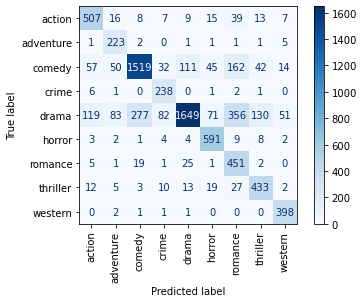

In [50]:
evaluate_model(nb_grid, X_train, y_train)

              precision    recall  f1-score   support

      action       0.46      0.49      0.48       209
   adventure       0.45      0.67      0.54        96
      comedy       0.65      0.59      0.62       692
       crime       0.32      0.53      0.40        79
       drama       0.70      0.44      0.54       952
      horror       0.66      0.76      0.71       216
     romance       0.27      0.65      0.38       144
    thriller       0.24      0.30      0.27       161
     western       0.74      0.96      0.83       122

    accuracy                           0.55      2671
   macro avg       0.50      0.60      0.53      2671
weighted avg       0.60      0.55      0.55      2671



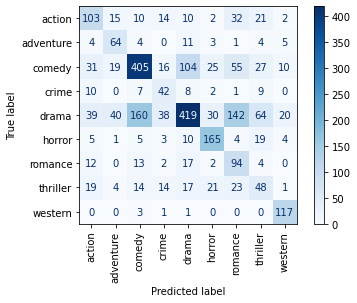

In [51]:
evaluate_model(nb_grid, X_test, y_test)

**RandomForest Pipeline**

In [52]:
rf_pipeline = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(min_df=10, max_df=0.9)),
    ('rf', RandomForestClassifier(n_estimators=10)),
])

In [53]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.9, min_df=10)),
                ('rf', RandomForestClassifier(n_estimators=10))])

In [54]:
pd.DataFrame(rf_pipeline.predict(X_test)).value_counts()

drama        1469
comedy        862
action        113
horror         99
western        54
thriller       26
romance        19
adventure      18
crime          11
dtype: int64

In [55]:
#y_pred = rf_pipeline.predict(X_test)
f1_score(y_test, rf_pipeline.predict(X_test), average = 'weighted')

0.39198300723809504

              precision    recall  f1-score   support

      action       1.00      0.99      0.99       621
   adventure       1.00      0.97      0.98       235
      comedy       0.98      0.99      0.99      2032
       crime       1.00      0.96      0.98       249
       drama       0.97      1.00      0.99      2818
      horror       1.00      0.97      0.99       624
     romance       1.00      0.93      0.96       505
    thriller       1.00      0.98      0.99       524
     western       1.00      0.99      0.99       403

    accuracy                           0.99      8011
   macro avg       0.99      0.98      0.98      8011
weighted avg       0.99      0.99      0.99      8011



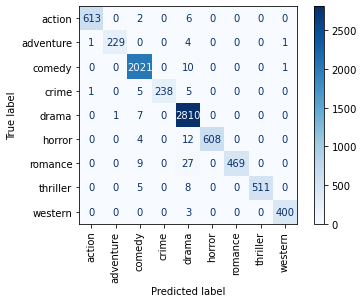

In [56]:
evaluate_model(rf_pipeline, X_train, y_train)

              precision    recall  f1-score   support

      action       0.34      0.18      0.24       209
   adventure       0.33      0.06      0.11        96
      comedy       0.40      0.50      0.45       692
       crime       0.18      0.03      0.04        79
       drama       0.44      0.68      0.54       952
      horror       0.66      0.30      0.41       216
     romance       0.26      0.03      0.06       144
    thriller       0.08      0.01      0.02       161
     western       0.83      0.37      0.51       122

    accuracy                           0.43      2671
   macro avg       0.39      0.24      0.26      2671
weighted avg       0.42      0.43      0.39      2671



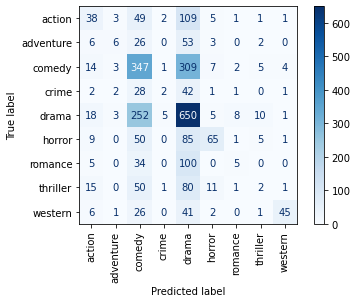

In [57]:
evaluate_model(rf_pipeline, X_test, y_test)

**voting classifier**

In [58]:
nb=MultinomialNB()
rf=RandomForestClassifier()
svc=SVC()

In [59]:
vc_pipeline = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(min_df=10,max_df=.8)),
    ('vc', VotingClassifier(
                estimators=[('randomforest', rf), ('NaiveBayes', nb), ('SupportVector', svc)], 
                voting='hard')),
    
])

In [60]:
vc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.8, min_df=10)),
                ('vc',
                 VotingClassifier(estimators=[('randomforest',
                                               RandomForestClassifier()),
                                              ('NaiveBayes', MultinomialNB()),
                                              ('SupportVector', SVC())]))])

In [61]:
f1_score(y_test, vc_pipeline.predict(X_test),average = 'weighted')

0.4526630505394549

              precision    recall  f1-score   support

      action       0.98      0.94      0.96       621
   adventure       1.00      0.85      0.92       235
      comedy       0.96      0.98      0.97      2032
       crime       1.00      0.73      0.85       249
       drama       0.89      1.00      0.94      2818
      horror       0.99      0.98      0.99       624
     romance       1.00      0.77      0.87       505
    thriller       1.00      0.78      0.88       524
     western       1.00      0.99      0.99       403

    accuracy                           0.95      8011
   macro avg       0.98      0.89      0.93      8011
weighted avg       0.95      0.95      0.95      8011



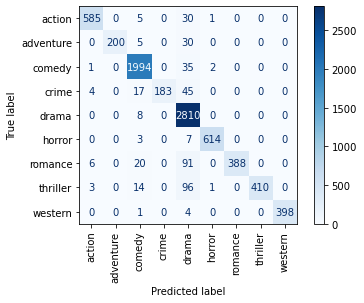

In [62]:
evaluate_model(vc_pipeline, X_train, y_train)

              precision    recall  f1-score   support

      action       0.63      0.13      0.21       209
   adventure       1.00      0.07      0.14        96
      comedy       0.66      0.48      0.55       692
       crime       0.50      0.01      0.02        79
       drama       0.45      0.92      0.60       952
      horror       0.94      0.38      0.54       216
     romance       0.60      0.02      0.04       144
    thriller       0.00      0.00      0.00       161
     western       0.89      0.44      0.59       122

    accuracy                           0.52      2671
   macro avg       0.63      0.27      0.30      2671
weighted avg       0.58      0.52      0.45      2671



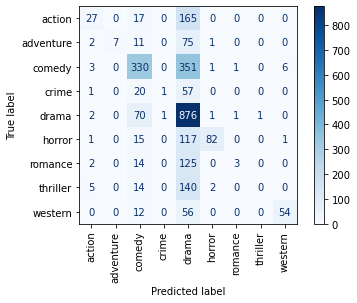

In [63]:
evaluate_model(vc_pipeline, X_test, y_test)

### Task #7: Run predictions and analyze the results on the test set to identify the best model.  

### Task #8: Refit the model to all of your data and then use that model to predict the holdout set. 

In [77]:
final_model = lr_pipeline.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


max_iter reached after 34 seconds


C:\Users\acumu\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   33.8s finished


              precision    recall  f1-score   support

      action       0.75      0.90      0.82       830
   adventure       0.64      0.99      0.78       331
      comedy       0.82      0.77      0.80      2724
       crime       0.63      1.00      0.77       328
       drama       0.92      0.63      0.74      3770
      horror       0.84      0.97      0.90       840
     romance       0.57      0.94      0.71       649
    thriller       0.70      0.91      0.79       685
     western       0.86      1.00      0.92       525

    accuracy                           0.79     10682
   macro avg       0.75      0.90      0.80     10682
weighted avg       0.82      0.79      0.79     10682



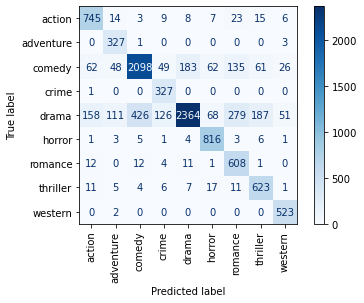

In [78]:
evaluate_model(final_model, X, y)

In [97]:
final_model['lr'].coef_

array([[ 0.23274062,  0.18652567, -0.09908878, ...,  0.18518945,
        -0.18335026, -0.02662697],
       [-0.09140639, -0.10056387,  0.02677102, ...,  0.03242738,
         0.05418629, -0.02088399],
       [-0.01167812,  0.39334754, -0.09082925, ...,  0.20179684,
         0.00675777, -0.03143492],
       ...,
       [-0.23167067,  0.0475323 ,  0.16741472, ...,  0.09231236,
         0.67184213,  0.07026928],
       [ 0.54826106, -0.26737405,  0.13178324, ..., -0.09466909,
        -0.21511235, -0.02604881],
       [-0.06505032, -0.14115529,  0.02189254, ..., -0.11216531,
        -0.11087303, -0.01073552]])

In [80]:
final_model['lr'].coef_.shape

(9, 24208)

**Holdout Set**

In [103]:
df2 = pd.read_csv('data/movie_test.csv', index_col=0)
df2.head()

,Release Year,Title,Plot,Director,Cast
5075,1950,Chain Gang,After a state senator's bill to abolish chain ...,Lew Landers,"Douglas Kennedy, Marjorie Lord"
32149,2003,Aithe,Irfan Khan (Pavan Malhotra) is a key mafia aff...,Chandrashekar Yeleti,"Sashank, Sindhu Tolani, Abhishek, Mohit"
7154,1958,Wild Heritage,The film tells the story of Emma Breslin (O'Su...,Charles Haas,"Will Rogers, Jr., Maureen O'Sullivan"
4259,1946,In Fast Company,The boys are involved in an altercation with a...,Del Lord,"The Bowery Boys, Jane Randolph"
7548,1961,"Stop, Look and Laugh",Paul Winchell plays a father to Jerry Mahoney ...,"Don Appell, Louis Brandt","Three Stooges, Paul Winchell"


In [82]:
df2.shape

(3561, 5)

In [83]:
df2.isnull().sum()

Release Year     0
Title            0
Plot             0
Director         0
Cast            57
dtype: int64

In [84]:
# Drop release year
df2.drop(columns=['Release Year'], inplace=True)

In [85]:
plot_target_2 = df2[['Plot']]

In [86]:
plot_target_2.head()

,Plot
5075,After a state senator's bill to abolish chain ...
32149,Irfan Khan (Pavan Malhotra) is a key mafia aff...
7154,The film tells the story of Emma Breslin (O'Su...
4259,The boys are involved in an altercation with a...
7548,Paul Winchell plays a father to Jerry Mahoney ...


In [87]:
plot_target_2.shape

(3561, 1)

In [ ]:
processed_plot_2 = list(map(doc_preparer, plot_target_2['Plot']))

In [90]:
predictions=final_model.predict(processed_plot_2)

In [91]:
predictions.shape

(3561,)

In [92]:
predictions

array(['crime', 'action', 'western', ..., 'crime', 'drama', 'thriller'],
      dtype=object)

In [93]:
answers = pd.DataFrame(predictions)
answers.index=plot_target_2.index

In [95]:
answers.head()

,0
5075,crime
32149,action
7154,western
4259,comedy
7548,comedy


### #9: Save your predictions as a csv file that you will send to the instructional staff for evaluation. 

In [104]:
answers.to_csv('nlp_preds_adam_cumurcu.csv')

## Great job!